In [2]:
# Cell 1 — Install & imports
!pip install -q git+https://github.com/openai/CLIP.git pillow==9.5.0 # optional CLIP (may already exist)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, utils
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm# Cell 4 — Simple U-Net components (GELUConvBlock, Down, Up)
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=None):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.norm = nn.BatchNorm2d(out_ch)
        self.act = nn.GELU()
        if time_emb_dim is not None:
            self.time_mlp = nn.Sequential(
                nn.GELU(),
                nn.Linear(time_emb_dim, out_ch)
            )
        else:
            self.time_mlp = None

    def forward(self, x, t_emb=None):
        h = self.conv(x)
        if self.time_mlp is not None and t_emb is not None:
            # add time embedding (broadcast)
            time_out = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
            h = h + time_out
        h = self.norm(h)
        return self.act(h)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=None):
        super().__init__()
        self.block = GELUConvBlock(in_ch, out_ch, time_emb_dim)
        self.pool = nn.AvgPool2d(2)

    def forward(self, x, t):
        x = self.block(x, t)
        return self.pool(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=None):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.block = GELUConvBlock(in_ch, out_ch, time_emb_dim)

    def forward(self, x, skip, t):
        x = self.upsample(x)
        # concat on channel dim
        x = torch.cat([x, skip], dim=1)
        return self.block(x, t)

import math
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


# Cell 2 — Dataset (MNIST) setup, dataloaders
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                     transform=transforms.Compose([
                                         transforms.ToTensor(), # 1x28x28, values [0,1]
                                         transforms.Normalize([0.5],[0.5]) # [-1,1]
                                     ]))
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# show some images
imgs, labels = next(iter(train_loader))
grid = utils.make_grid((imgs[:16]*0.5+0.5), nrow=4) # unnormalize
plt.figure(figsize=(5,5))
plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray')
plt.title('Sample training images'); plt.axis('off')

# Cell 3 — Utility: sinusoidal time embedding
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        half = dim // 2
        self.register_buffer('inv_freq', 1.0 / (10000 ** (torch.arange(0, half).float() / half)))
    def forward(self, t):
        # t shape: (batch,)
        t = t.float().unsqueeze(1) # (B,1)
        freqs = t * self.inv_freq.unsqueeze(0)  # (B,half)
        emb = torch.cat([torch.sin(freqs), torch.cos(freqs)], dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0,1))
        return emb  # (B, dim)
# Cell 3 — Utility: sinusoidal time embedding
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        half = dim // 2
        self.register_buffer('inv_freq', 1.0 / (10000 ** (torch.arange(0, half).float() / half)))
    def forward(self, t):
        # t shape: (batch,)
        t = t.float().unsqueeze(1) # (B,1)
        freqs = t * self.inv_freq.unsqueeze(0)  # (B,half)
        emb = torch.cat([torch.sin(freqs), torch.cos(freqs)], dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0,1))
        return emb  # (B, dim)# Cell 5 — Small UNet for 28x28 grayscale
class UNet(nn.Module):
    def __init__(self, in_channels=1, base_ch=64, time_emb_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            TimeEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.GELU()
        )
        # encoder
        self.inc = GELUConvBlock(in_channels, base_ch, time_emb_dim)
        self.down1 = Down(base_ch, base_ch*2, time_emb_dim)
        self.down2 = Down(base_ch*2, base_ch*4, time_emb_dim)
        # bottleneck
        self.bot = GELUConvBlock(base_ch*4, base_ch*4, time_emb_dim)
        # decoder
        self.up2 = Up(base_ch*4 + base_ch*4, base_ch*2, time_emb_dim)
        self.up1 = Up(base_ch*2 + base_ch*2, base_ch, time_emb_dim)
        self.out_conv = nn.Conv2d(base_ch, in_channels, kernel_size=1)

    def forward(self, x, t):
        # x: (B,1,28,28) in [-1,1]
        t_emb = self.time_mlp(t)  # (B, time_emb_dim)
        x1 = self.inc(x, t_emb)   # (B,base,28,28)
        x2 = self.down1(x1, t_emb) # (B,base*2,14,14)
        x3 = self.down2(x2, t_emb) # (B,base*4,7,7)
        b = self.bot(x3, t_emb)
        u2 = self.up2(b, x3, t_emb)
        u1 = self.up1(u2, x2, t_emb)
        out = self.out_conv(u1)
        return out
# Cell 6 — Diffusion schedule and helper functions (forward q_sample, predict_noise loss)
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

T = 200  # number of diffusion steps (can reduce to 100 for quick runs)
betas = linear_beta_schedule(T).to(device)
alphas = 1. - betas
alpha_hat = torch.cumprod(alphas, dim=0)  # \bar{\alpha}_t

def q_sample(x0, t, noise=None):
    """
    x0: real images in [-1,1], shape (B,C,H,W)
    t: timesteps tensor (B,)
    """
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t]).view(-1,1,1,1)
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t]).view(-1,1,1,1)
    return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise

# helper to get time index tensor
def sample_timesteps(batch_size):
    return torch.randint(0, T, (batch_size,), device=device)
# Cell 7 — Loss function and training step
model = UNet(in_channels=1, base_ch=64, time_emb_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
mse = nn.MSELoss()

def p_losses(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    x_noisy = q_sample(x0, t, noise)
    predicted_noise = model(x_noisy, t)
    return mse(noise, predicted_noise)

# single training step inside loop below
# Cell 9 — Training loop (small number of epochs for quick results)
epochs = 5  # increase for better quality (10-30)
log_interval = 200
save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)
global_step = 0
for epoch in range(epochs):
    pbar = tqdm(train_loader)
    for imgs, _ in pbar:
        imgs = imgs.to(device)
        b = imgs.size(0)
        t = sample_timesteps(b)
        loss = p_losses(imgs, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        global_step += 1
        if global_step % log_interval == 0:
            pbar.set_description(f"Epoch {epoch} step {global_step} loss {loss.item():.4f}")
    # sample and save after each epoch
    sampled = sample(model, n_samples=16).cpu()
    grid = utils.make_grid((sampled*0.5+0.5), nrow=4)
    plt.figure(figsize=(5,5)); plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray'); plt.axis('off')
    plt.title(f'Samples after epoch {epoch}'); plt.show()
    torch.save(model.state_dict(), os.path.join(save_dir, f"unet_epoch{epoch}.pt"))
# Cell 10 — Visualize generation steps for one sample (intermediate timesteps)
@torch.no_grad()
def visualize_process(model, x0=None, chosen_t=None):
    model.eval()
    if x0 is None:
        x0 = torch.randn(1,1,28,28, device=device)
    # create noisy versions at a few timesteps
    timesteps_to_show = [0, 5, 10, 20, 50, 100, 150, 199]  # adapt to T
    imgs = []
    for t in timesteps_to_show:
        if t >= T: continue
        t_tensor = torch.tensor([t], device=device)
        noise = torch.randn_like(x0)
        x_noisy = q_sample(x0, t_tensor, noise)
        # apply one-step denoising for visualization
        pred_noise = model(x_noisy, t_tensor)
        # estimate x0
        x0_pred = (x_noisy - torch.sqrt(1-alpha_hat[t]) * pred_noise) / torch.sqrt(alpha_hat[t])
        imgs.append(x_noisy.cpu().squeeze().numpy())
    # plot
    fig, axs = plt.subplots(1, len(imgs), figsize=(2*len(imgs),2))
    for ax, im, t in zip(axs, imgs, timesteps_to_show[:len(imgs)]):
        ax.imshow((im*0.5+0.5).squeeze(), cmap='gray')
        ax.set_title(f"t={t}")
        ax.axis('off')
    plt.show()
    model.train()

# call it:
visualize_process(model)
# Cell 11 — Optional: CLIP evaluation (note: CLIP is trained on natural images — limited use for MNIST)
# This is optional/bonus. It will compute CLIP embeddings for generated images and compare to class text prompts.
import clip
clip_model, preprocess = clip.load("ViT-B/32", device=device)
# prepare generated images (convert to 3-channel and to [0,1])
sampled = sample(model, n_samples=32).cpu()
sampled_rgb = sampled.repeat(1,3,1,1) # stack channels
sampled_rgb = (sampled_rgb*0.5+0.5).clamp(0,1)
# phrases for digits
texts = [f"a photo of the digit {i}" for i in range(10)]
text_tokens = clip.tokenize(texts).to(device)
with torch.no_grad():
    text_feats = clip_model.encode_text(text_tokens)
    img_feats = clip_model.encode_image(sampled_rgb.to(device))
    # compute similarity scores
    sim = (img_feats @ text_feats.T).cpu().numpy()
# print top-1 predicted digits for the first few samples
preds = np.argmax(sim, axis=1)
print("CLIP predicted digits for generated images (first 16):", preds[:16])



  Preparing metadata (setup.py) ... done


ImportError: cannot import name 'is_directory' from 'PIL._util' (/usr/local/lib/python3.12/dist-packages/PIL/_util.py)

Pillow version: 9.5.0, torchvision version: 0.24.0+cu128
Using device: cpu
torch version: 2.9.0+cu128 torchvision version: 0.24.0+cu128 Pillow: 9.5.0


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


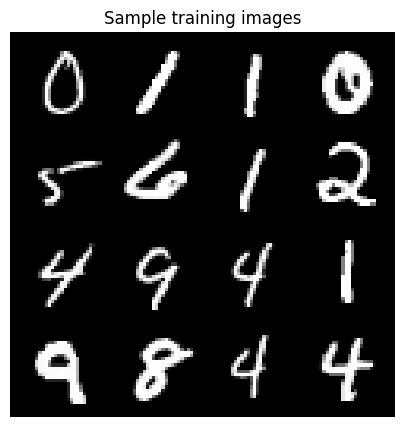

Starting training... (this may take some time depending on GPU)


Epoch 0: 100%|██████████| 430/430 [43:38<00:00,  6.09s/it, loss=0.0734]


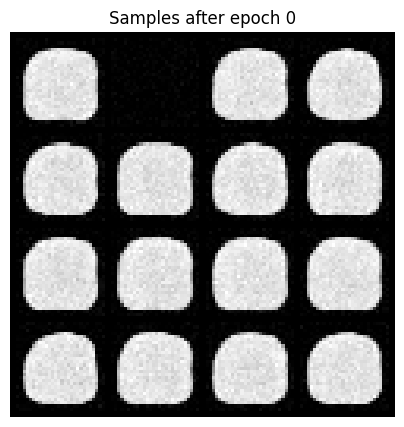

Epoch 1: 100%|██████████| 430/430 [43:21<00:00,  6.05s/it, loss=0.0737]


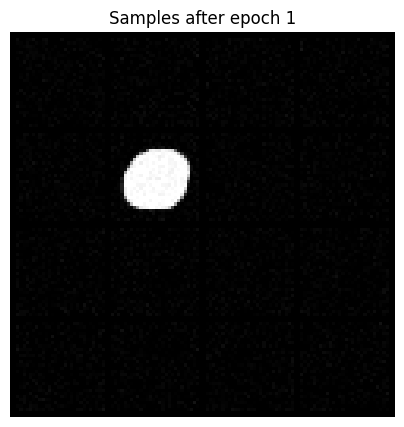

Epoch 2: 100%|██████████| 430/430 [43:12<00:00,  6.03s/it, loss=0.0693]


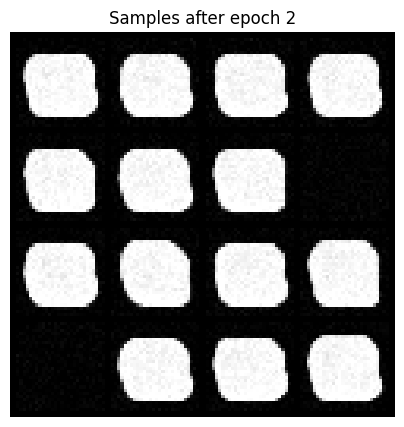

Epoch 3: 100%|██████████| 430/430 [43:06<00:00,  6.02s/it, loss=0.0767]


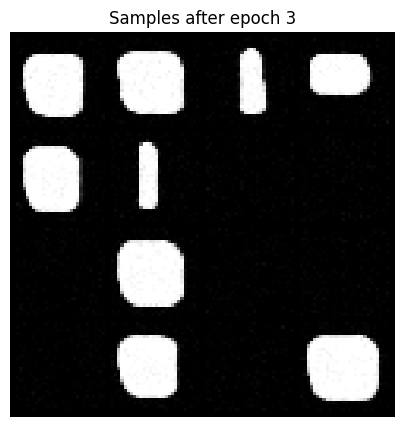

Epoch 4: 100%|██████████| 430/430 [43:38<00:00,  6.09s/it, loss=0.0575]


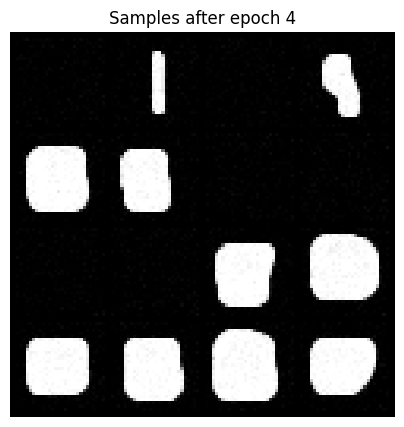

Training finished. Save dir: ./checkpoints


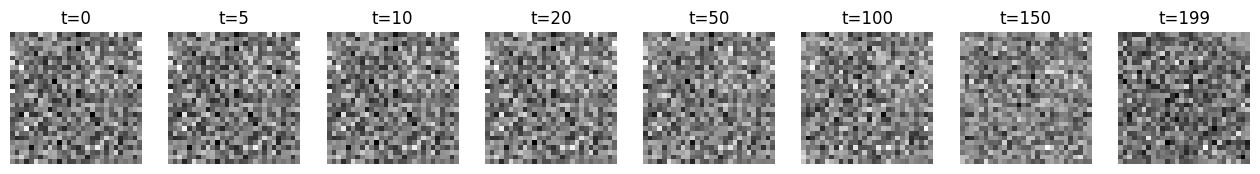

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 70.9MiB/s]


CLIP loaded. Example CLIP evaluation code available.


In [3]:
# ONE BIG CELL: Fix Pillow/torchvision conflict, then full MNIST diffusion pipeline (UNet + training + sampling)
# Run in Google Colab (Runtime -> Change runtime type -> GPU). This cell may restart the runtime during package install.

import sys, os, subprocess, time

def install_and_restart(pkgs):
    """Install packages via pip and then force a runtime restart (Colab-friendly)."""
    print("Installing:", pkgs)
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)
    print("Installation complete. Restarting Python runtime to apply changes...")
    # Force restart (Colab will prompt reconnect)
    os.kill(os.getpid(), 9)

# --- 1) Ensure compatible Pillow & torchvision to avoid ImportError ---
need_install = False
try:
    import PIL
    import torchvision
    pil_ver = tuple(map(int, PIL.__version__.split(".")[:2]))
    tv_ver = tuple(map(int, torchvision.__version__.split(".")[:2]))
    print(f"Pillow version: {PIL.__version__}, torchvision version: {torchvision.__version__}")
    # If torchvision is old relative to Pillow, upgrade torchvision. This is a heuristic.
    # If pillow >= 9 and torchvision < 0.12, upgrade torchvision.
    # Adjusting heuristic based on observed common issues
    if pil_ver[0] >= 9 and (tv_ver[0] < 0 or (tv_ver[0] == 0 and tv_ver[1] < 14)): # Target torchvision 0.14 or higher for Pillow >= 9
         need_install = True
except Exception as e:
    # If import fails, request install
    print("Import error or missing packages:", e)
    need_install = True

if need_install:
    # Choose a recent torchvision that is usually compatible with Colab's torch.
    # We avoid forcing torch version to reduce conflicts; just upgrade torchvision and pillow.
    # If you want a specific torch+torchvision pairing, change these pins.
    pkgs = ["--upgrade", "pillow==9.5.0", "torchvision>=0.14"] # Pin torchvision to >= 0.14
    install_and_restart(pkgs)

# If we reached here after a restart (or no install needed), continue with imports and model code.
# Note: If runtime restarted, re-run this cell from top — it will skip installation and run the rest.

# --- Standard imports ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, utils
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import math
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
print("torch version:", torch.__version__, "torchvision version:", torchvision.__version__, "Pillow:", __import__('PIL').__version__)

# --- Reproducibility (optional) ---
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed)

# -------------------------
# Dataset + dataloaders (MNIST) - UNCOMMENT CIFAR/Fashion block if you want to use those datasets & adjust model
# -------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # scale to [-1,1]
])
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# quick preview
imgs, labels = next(iter(train_loader))
grid = utils.make_grid((imgs[:16]*0.5+0.5), nrow=4)
plt.figure(figsize=(5,5))
plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray')
plt.title('Sample training images'); plt.axis('off')
plt.show()

# -------------------------
# Model building blocks
# -------------------------
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        half = dim // 2
        inv_freq = 1.0 / (10000 ** (torch.arange(0, half).float() / half))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, t):
        # t shape: (B,) integer timesteps
        t = t.float().unsqueeze(1)  # (B,1)
        freqs = t * self.inv_freq.unsqueeze(0)  # (B, half)
        emb = torch.cat([torch.sin(freqs), torch.cos(freqs)], dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0,1))
        return emb  # (B, dim)

class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=None):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.norm = nn.BatchNorm2d(out_ch)
        self.act = nn.GELU()
        if time_emb_dim is not None:
            self.time_mlp = nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, out_ch))
        else:
            self.time_mlp = None

    def forward(self, x, t_emb=None):
        h = self.conv(x)
        if self.time_mlp is not None and t_emb is not None:
            time_out = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
            h = h + time_out
        h = self.norm(h)
        return self.act(h)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=None):
        super().__init__()
        self.block = GELUConvBlock(in_ch, out_ch, time_emb_dim)
        self.pool = nn.AvgPool2d(2)

    def forward(self, x, t):
        x = self.block(x, t)
        return self.pool(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=None):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.block = GELUConvBlock(in_ch, out_ch, time_emb_dim)

    def forward(self, x, skip, t):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        return self.block(x, t)

# -------------------------
# UNet
# -------------------------
class UNet(nn.Module):
    def __init__(self, in_channels=1, base_ch=64, time_emb_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(TimeEmbedding(time_emb_dim), nn.Linear(time_emb_dim, time_emb_dim), nn.GELU())
        self.inc = GELUConvBlock(in_channels, base_ch, time_emb_dim)
        self.down1 = Down(base_ch, base_ch*2, time_emb_dim)
        self.down2 = Down(base_ch*2, base_ch*4, time_emb_dim)
        self.bot = GELUConvBlock(base_ch*4, base_ch*4, time_emb_dim)
        # Corrected input channels for Up layers and skip connections
        self.up2 = Up(base_ch*4 + base_ch*2, base_ch*2, time_emb_dim) # bottleneck (base*4) + skip from down1 (base*2)
        self.up1 = Up(base_ch*2 + base_ch, base_ch, time_emb_dim) # upsampled from up2 (base*2) + skip from inc (base)
        self.out_conv = nn.Conv2d(base_ch, in_channels, kernel_size=1)

    def forward(self, x, t):
        # t: (B,) long
        t_emb = self.time_mlp(t)
        x1 = self.inc(x, t_emb)       # (B, base, 28,28)
        x2 = self.down1(x1, t_emb)    # (B, base*2, 14,14)
        x3 = self.down2(x2, t_emb)    # (B, base*4, 7,7)
        b = self.bot(x3, t_emb)       # (B, base*4, 7,7)
        # Corrected skip connections
        u2 = self.up2(b, x2, t_emb)   # Use x2 as skip connection for up2
        u1 = self.up1(u2, x1, t_emb)  # Use x1 as skip connection for up1
        out = self.out_conv(u1)
        return out

# -------------------------
# Diffusion schedule and helpers
# -------------------------
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

T = 200  # diffusion timesteps (reduce to 100 for faster runs)
betas = linear_beta_schedule(T).to(device)
alphas = 1. - betas
alpha_hat = torch.cumprod(alphas, dim=0)  # \bar{\alpha}_t

def q_sample(x0, t, noise=None):
    """
    Forward process: sample x_t from q(x_t | x_0)
    x0: (B,C,H,W)
    t: (B,) long
    """
    if noise is None:
        noise = torch.randn_like(x0)
    # index into alpha_hat
    a_hat = alpha_hat[t].view(-1,1,1,1)
    sqrt_a_hat = torch.sqrt(a_hat)
    sqrt_1_minus_a_hat = torch.sqrt(1. - a_hat)
    return sqrt_a_hat * x0 + sqrt_1_minus_a_hat * noise

def sample_timesteps(batch_size):
    return torch.randint(0, T, (batch_size,), device=device, dtype=torch.long)

# -------------------------
# Training utils + model instantiation
# -------------------------
model = UNet(in_channels=1, base_ch=64, time_emb_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
mse = nn.MSELoss()

def p_losses(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    x_noisy = q_sample(x0, t, noise)
    predicted_noise = model(x_noisy, t)
    return mse(noise, predicted_noise)

@torch.no_grad()
def sample(model, n_samples=16, T_local=T):
    model.eval()
    x = torch.randn(n_samples, 1, 28, 28, device=device)
    for i in reversed(range(T_local)):
        t = torch.full((n_samples,), i, device=device, dtype=torch.long)
        predicted_noise = model(x, t)
        a = alphas[i].to(device)
        a_hat_i = alpha_hat[i].to(device)
        b = betas[i].to(device)
        # estimate x0
        x0_pred = (x - torch.sqrt(1.-a_hat_i) * predicted_noise) / torch.sqrt(a_hat_i)
        # compute posterior mean approximation
        mean = torch.sqrt(a) * x0_pred + torch.sqrt(1. - a) * predicted_noise
        if i > 0:
            z = torch.randn_like(x)
            sigma = torch.sqrt(b)
            x = mean + sigma * z
        else:
            x = mean
    model.train()
    return x

# -------------------------
# Training loop (short by default)
# -------------------------
epochs = 10   # Increased epochs for continued training
log_interval = 200
save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)
global_step = 0

# Load latest checkpoint if it exists to continue training
latest_checkpoint = None
if os.path.exists(save_dir):
    checkpoints = [f for f in os.listdir(save_dir) if f.startswith("unet_epoch") and f.endswith(".pth")]
    if checkpoints:
        # Find the checkpoint with the highest epoch number
        latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('epoch')[1].split('.')[0]))
        latest_checkpoint_path = os.path.join(save_dir, latest_checkpoint)
        print(f"Loading checkpoint: {latest_checkpoint_path}")
        model.load_state_dict(torch.load(latest_checkpoint_path))
        # Determine the starting epoch from the loaded checkpoint
        start_epoch = int(latest_checkpoint.split('epoch')[1].split('.')[0]) + 1
    else:
        start_epoch = 0
else:
    start_epoch = 0

print(f"Starting training from epoch {start_epoch}... (this may take some time depending on GPU)")

for epoch in range(start_epoch, epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for imgs, _ in pbar:
        imgs = imgs.to(device)
        b = imgs.size(0)
        t = sample_timesteps(b)
        loss = p_losses(imgs, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        global_step += 1
        if global_step % log_interval == 0:
            pbar.set_postfix(loss=loss.item())
    # sample and display after each epoch
    sampled = sample(model, n_samples=16)
    sampled_cpu = sampled.cpu()
    grid = utils.make_grid((sampled_cpu*0.5+0.5), nrow=4)
    plt.figure(figsize=(5,5)); plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray'); plt.axis('off')
    plt.title(f'Samples after epoch {epoch}'); plt.show()
    torch.save(model.state_dict(), os.path.join(save_dir, f"unet_epoch{epoch}.pth"))

print("Training finished. Save dir:", save_dir)

# -------------------------
# Visualize generation process for a single random sample across timesteps
# -------------------------
@torch.no_grad()
def visualize_process(model):
    model.eval()
    x0 = torch.randn(1,1,28,28, device=device)
    timesteps_to_show = [0, 5, 10, 20, 50, 100, 150, T-1]
    imgs = []
    for t in timesteps_to_show:
        if t >= T: continue
        t_tensor = torch.tensor([t], device=device)
        noise = torch.randn_like(x0)
        x_noisy = q_sample(x0, t_tensor, noise)
        pred_noise = model(x_noisy, t_tensor)
        # estimate x0 (one-step prediction)
        x0_pred = (x_noisy - torch.sqrt(1.-alpha_hat[t]) * pred_noise) / torch.sqrt(alpha_hat[t])
        imgs.append(x_noisy.cpu().squeeze().numpy())
    fig, axs = plt.subplots(1, len(imgs), figsize=(2*len(imgs),2))
    for ax, im, t in zip(axs, imgs, timesteps_to_show[:len(imgs)]):
        ax.imshow((im*0.5+0.5).squeeze(), cmap='gray')
        ax.set_title(f"t={t}")
        ax.axis('off')
    plt.show()
    model.train()

visualize_process(model)

# -------------------------
# Optional: CLIP evaluation (only if CLIP installed) - Not necessary for MNIST but included as placeholder
# -------------------------
try:
    import clip
    clip_model, preprocess = clip.load("ViT-B/32", device=device)
    print("CLIP loaded. Example CLIP evaluation code available.")
except Exception as e:
    print("CLIP not available or failed to load (this is optional). Skipping CLIP eval. Error:", e)

# End of big cell.